In [1]:
import sys

sys.path.append("./optimisation_service")
sys.path.append("./epoch_simulator_lib/build/epoch_py/")

sys.path[0], sys.path[-1] = sys.path[-1], sys.path[0]

In [2]:
from app.models.epoch_types.site_range_type import Building, Config, GasHeater, GasTypeEnum, Grid, SolarPanel, SiteRange, HeatPump, HeatSourceEnum, DomesticHotWater, BatteryModeEnum, EnergyStorageSystem
import numpy as np

site_ranges = {}

building = Building(
    COMPONENT_IS_MANDATORY=True,
    scalar_heat_load=[1],
    scalar_electrical_load=[1],
    fabric_intervention_index=list(range(64)),
    incumbent=False,
    age=0,
)
config = Config(capex_limit=99999999999, use_boiler_upgrade_scheme=False, general_grant_funding=0.0)
grid = Grid(
    COMPONENT_IS_MANDATORY=True,
    import_headroom=[0.4],
    grid_export=[999],
    grid_import=[999],
    tariff_index=[0, 1, 3],
    export_tariff=[0.15],
    incumbent=True,
    age=0,
)
heat_pump = HeatPump(
    COMPONENT_IS_MANDATORY = False,
    heat_power = list(range(50))[1:],
    heat_source = [HeatSourceEnum.AMBIENT_AIR],
    send_temp = [2.0],
    incumbent = False,
    age = 0,
    lifetime = 10
)
domestic_hot_water = DomesticHotWater(
    COMPONENT_IS_MANDATORY = False,
    cylinder_volume = list(range(200))[1:],
    incumbent = False,
    age = 0,
    lifetime = 12,
)
energy_storage_system = EnergyStorageSystem(
    COMPONENT_IS_MANDATORY = False,
    capacity = list(range(100))[1:],
    charge_power = list(range(50))[1:],
    discharge_power = list(range(50))[1:],
    battery_mode = [BatteryModeEnum.CONSUME, BatteryModeEnum.CONSUME_PLUS],
    initial_charge = [0.0],
    incumbent = False,
    age = 0,
    lifetime = 15,
)

In [3]:
solar_panels_A = [
    SolarPanel(
        COMPONENT_IS_MANDATORY=True, yield_scalar=[10.8], yield_index=[0], incumbent=True, age=0, lifetime=25
    ),
    SolarPanel(
        COMPONENT_IS_MANDATORY=True, yield_scalar=[36.0], yield_index=[0], incumbent=True, age=0, lifetime=25
    )
]
domestic_hot_water_A = DomesticHotWater(
    COMPONENT_IS_MANDATORY = False,
    cylinder_volume = [150],
    incumbent = True,
    age = 0,
    lifetime = 12,
)
heat_pump_A = HeatPump(
    COMPONENT_IS_MANDATORY = True,
    heat_power = [200.0],
    heat_source = [HeatSourceEnum.AMBIENT_AIR],
    send_temp = [2.0],
    incumbent = True,
    age = 0,
    lifetime = 10
)

site_ranges["A"] = SiteRange(building=building, grid=grid, solar_panels=solar_panels_A, heat_pump=heat_pump_A, domestic_hot_water=domestic_hot_water_A, energy_storage_system=energy_storage_system)

In [4]:
solar_panels_B = [
    SolarPanel(
        COMPONENT_IS_MANDATORY=False, yield_scalar=np.arange(0.5, 8.0, 0.5).tolist(), yield_index=[0], incumbent=False, age=0, lifetime=25
    ),
    SolarPanel(
        COMPONENT_IS_MANDATORY=False, yield_scalar=np.arange(0.5, 3.0, 0.5).tolist(), yield_index=[0], incumbent=False, age=0, lifetime=25
    ),
    SolarPanel(
        COMPONENT_IS_MANDATORY=False, yield_scalar=np.arange(0.5, 6.0, 0.5).tolist(), yield_index=[0], incumbent=False, age=0, lifetime=25
    )
]
gas_heater_B = GasHeater(
    COMPONENT_IS_MANDATORY=False,
    maximum_output=[65],
    gas_type=[GasTypeEnum.NATURAL_GAS],
    boiler_efficiency=[0.944],
    incumbent=True,
    age=0,
)

site_ranges["B"] = SiteRange(building=building, grid=grid, gas_heater=gas_heater_B, solar_panels=solar_panels_B, heat_pump=heat_pump, domestic_hot_water=domestic_hot_water, energy_storage_system=energy_storage_system)

In [5]:
solar_panels_C = [
    SolarPanel(
        COMPONENT_IS_MANDATORY=False, yield_scalar=np.arange(0.5, 5.5, 0.5).tolist(), yield_index=[0], incumbent=False, age=0, lifetime=25
    ),
    SolarPanel(
        COMPONENT_IS_MANDATORY=False, yield_scalar=np.arange(0.5, 9.5, 0.5).tolist(), yield_index=[0], incumbent=False, age=0, lifetime=25
    ),
    SolarPanel(
        COMPONENT_IS_MANDATORY=False, yield_scalar=np.arange(0.5, 5.5, 0.5).tolist(), yield_index=[0], incumbent=False, age=0, lifetime=25
    ),
    SolarPanel(
        COMPONENT_IS_MANDATORY=False, yield_scalar=np.arange(0.5, 5.0, 0.5).tolist(), yield_index=[0], incumbent=False, age=0, lifetime=25
    )
]
gas_heater_C = GasHeater(
    COMPONENT_IS_MANDATORY=False,
    maximum_output=[20],
    gas_type=[GasTypeEnum.NATURAL_GAS],
    boiler_efficiency=[0.944],
    incumbent=True,
    age=0,
)

site_ranges["C"] = SiteRange(building=building, grid=grid, gas_heater=gas_heater_C, solar_panels=solar_panels_C, heat_pump=heat_pump, domestic_hot_water=domestic_hot_water, energy_storage_system=energy_storage_system)

In [6]:
import datetime
from pathlib import Path
from app.models.core import Site
from app.models.site_data import LegacySiteMetaData
from tests.conftest import load_epoch_data_from_file
from app.models.epoch_types.config import Config
from app.internal.constraints import apply_default_constraints
from app.models.constraints import Bounds
from app.models.metrics import Metric

site_ids = ["A", "B", "C"]
portfolio = []
for site_id in site_ids:
    start_ts = datetime.datetime(year=2022, month=1, day=1, hour=0, tzinfo=datetime.UTC)
    end_ts = datetime.datetime(year=2023, month=1, day=1, hour=0, tzinfo=datetime.UTC)
    site_data = LegacySiteMetaData(site_id=site_id, start_ts=start_ts, end_ts=end_ts)

    site = Site(name=site_id, site_range=site_ranges[site_id], site_data=site_data, constraints={}, config=Config())

    epoch_data = load_epoch_data_from_file(path=Path("bo_test_data", f"{site_id}.json"))

    site._epoch_data = epoch_data

    portfolio.append(site)

constraints = {Metric.capex: Bounds(max=100000)}

portfolio, constraints = apply_default_constraints(portfolio, constraints)

objectives = [Metric.npv_balance, Metric.carbon_balance_total]

In [7]:
results_by_algorithm = {}

In [8]:
from app.internal.NSGA2 import NSGA2

nsga = NSGA2(pop_size=1024, n_offsprings=512, period=10, tol=0.00001)

results_by_algorithm["NSGA-II"] = nsga.run(objectives=objectives, constraints=constraints, portfolio=portfolio)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |     1024 |      1 |  5.865703E+04 |  1.136631E+06 |             - |             -
     2 |     1536 |      1 |  5.865703E+04 |  7.542719E+05 |             - |             -
     3 |     2048 |      1 |  1.291784E+04 |  5.166016E+05 |             - |             -
     4 |     2560 |      1 |  1.291784E+04 |  3.587932E+05 |             - |             -
     5 |     3072 |      1 |  0.000000E+00 |  2.550881E+05 |             - |             -
     6 |     3584 |      1 |  0.000000E+00 |  1.855331E+05 |  0.000000E+00 |             f
     7 |     4096 |      1 |  0.000000E+00 |  1.367505E+05 |  1.297241E+05 |         ideal
     8 |     4608 |      3 |  0.000000E+00 |  1.007305E+05 |  0.9663257967 |         ideal
     9 |     5120 |      7 |  0.000000E+00 |  7.473273E+04 |  0.0716358080 |         ideal
    10 |     5632 |      8 |  0.000000E+00 |  5.302708E+04 |  0.0321857549 |         ideal

In [9]:
from app.internal.NSGA2 import SeparatedNSGA2

snsga = SeparatedNSGA2()

results_by_algorithm["SeparatedNSGA-II"] = snsga.run(objectives=objectives, constraints=constraints, portfolio=portfolio)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      125 |      3 |  0.000000E+00 |  4.642449E+05 |             - |             -
     2 |      189 |      3 |  0.000000E+00 |  1.858215E+05 |  0.000000E+00 |             f
     3 |      253 |      3 |  0.000000E+00 |  5.982940E+04 |  0.0464296777 |         nadir
     4 |      317 |      5 |  0.000000E+00 |  8.911396E+03 |  0.0074084332 |         ideal
     5 |      381 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0060989426 |             f
     6 |      445 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0028550078 |         ideal
     7 |      509 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0219107065 |             f
     8 |      573 |      5 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     9 |      637 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0189946614 |             f
    10 |      701 |      3 |  0.000000E+00 |  0.000000E+00 |  1.179581E+01 |         nadir

In [10]:
from app.internal.bayesian.bayesian import Bayesian as Old_Bayesian

from app.models.optimisers import NSGA2HyperParam

NSGA2_param = NSGA2HyperParam(pop_size=512, n_offsprings=256, period=10, tol=0.00001)

old_bo = Old_Bayesian(n_initialisation_points = 5, batch_size = 1, n_generations=10, NSGA2_param=NSGA2_param)

results_by_algorithm["Old_BO"] = old_bo.run(objectives=objectives, constraints=constraints, portfolio=portfolio)

/home/will/git_repos/EPOCH/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      432 |      2 |  0.000000E+00 |  4.258382E+05 |             - |             -
     2 |      688 |      2 |  0.000000E+00 |  1.906151E+05 |  0.000000E+00 |             f
     3 |      944 |      2 |  0.000000E+00 |  6.152223E+04 |  0.000000E+00 |             f
     4 |     1200 |      3 |  0.000000E+00 |  1.094946E+04 |  0.0152166523 |         ideal
     5 |     1456 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |     1712 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     7 |     1968 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0118391069 |             f
     8 |     2224 |      4 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     9 |     2480 |      4 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |     2736 |      4 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

In [11]:
from app.internal.bayesian.simplified_bo import Bayesian

from app.models.optimisers import NSGA2HyperParam

NSGA2_param = NSGA2HyperParam(pop_size=512, n_offsprings=256, period=10, tol=0.00001)

bo = Bayesian(n_initialisation_points = 5, batch_size = 1, n_generations=10, NSGA2_param=NSGA2_param)

results_by_algorithm["New_BO"] = bo.run(objectives=objectives, constraints=constraints, portfolio=portfolio)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      449 |      1 |  0.000000E+00 |  4.476160E+05 |             - |             -
     2 |      705 |      1 |  0.000000E+00 |  1.927518E+05 |  2.853750E+03 |         ideal
     3 |      961 |      1 |  0.000000E+00 |  5.852550E+04 |  0.000000E+00 |             f
     4 |     1217 |      1 |  0.000000E+00 |  1.014587E+04 |  0.000000E+00 |             f
     5 |     1473 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |     1729 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     7 |     1985 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     8 |     2241 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     9 |     2497 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |     2753 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

In [12]:
from typing import Iterable
import matplotlib.pyplot as plt
from app.models.result import OptimisationResult
from app.models.metrics import MetricDirection

def plot_pareto_fronts(
    results_by_algorithm: dict[str, OptimisationResult],
    objectives: list[Metric],
    *,
    title: str | None = None,
    show_feasible_only: bool = True,
) -> None:
    """
    Plot Pareto fronts for multiple optimisation algorithms, respecting
    metric direction (minimise vs maximise).

    Axes are transformed so that "better" solutions are always towards
    the bottom-left of the plot.
    """
    if len(objectives) != 2:
        raise ValueError("Exactly two objectives must be provided.")

    obj_x, obj_y = objectives

    dir_x = MetricDirection[obj_x.name]
    dir_y = MetricDirection[obj_y.name]

    fig, ax = plt.subplots(figsize=(8, 6))

    for algo_name, optimisation_result in results_by_algorithm.items():
        xs: list[float] = []
        ys: list[float] = []

        for solution in optimisation_result.solutions:
            if show_feasible_only and not solution.is_feasible:
                continue

            try:
                x = solution.metric_values[obj_x]
                y = solution.metric_values[obj_y]
            except KeyError as exc:
                raise KeyError(
                    f"Objective {exc.args[0]} not found in solution metric_values "
                    f"for algorithm '{algo_name}'."
                )

            xs.append(x)
            ys.append(y)

        if xs and ys:
            ax.scatter(xs, ys, label=algo_name, alpha=0.8)

    def axis_label(metric: Metric, direction: MetricDirection) -> str:
        arrow = "↓" if direction == 1 else "↑"
        verb = "minimise" if direction == 1 else "maximise"
        return f"{metric.value} ({verb} {arrow})"

    ax.set_xlabel(axis_label(obj_x, dir_x))
    ax.set_ylabel(axis_label(obj_y, dir_y))

    ax.set_title(title or "Pareto Front Comparison")
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

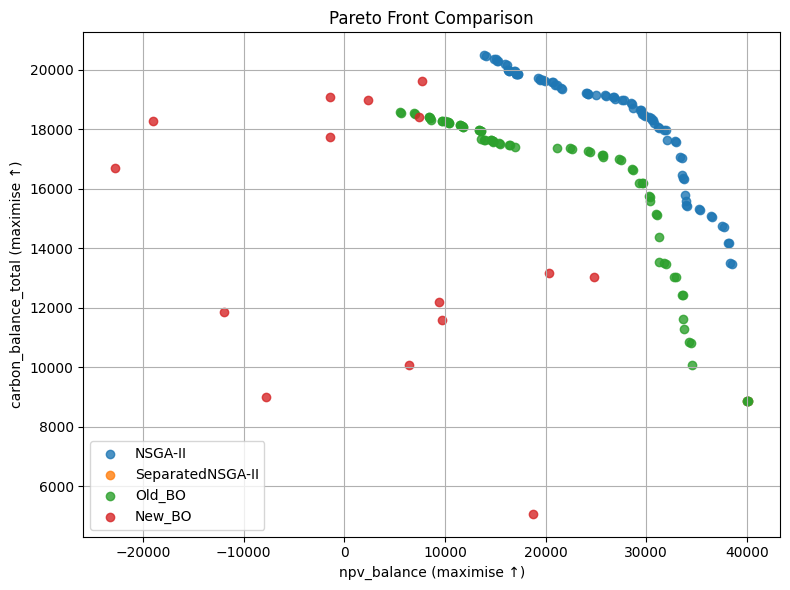

In [13]:
plot_pareto_fronts(results_by_algorithm=results_by_algorithm, objectives=objectives)

In [14]:
results_by_algorithm["New_BO"].solutions[0]

PortfolioSolution(scenario={'A': SiteSolution(scenario=AnnotatedTaskData(building=Building(scalar_heat_load=1.0, scalar_electrical_load=1.0, fabric_intervention_index=12, floor_area=None, incumbent=False, age=0.0, lifetime=30.0), data_centre=None, domestic_hot_water=None, electric_vehicles=None, energy_storage_system=None, gas_heater=None, grid=Grid(grid_export=999.0, grid_import=999.0, import_headroom=0.4, tariff_index=1, export_tariff=0.15, incumbent=True, age=0.0, lifetime=25.0), heat_pump=HeatPump(heat_power=200.0, heat_source=<HeatSource.AMBIENT_AIR: 'AMBIENT_AIR'>, send_temp=2.0, incumbent=True, age=0.0, lifetime=10.0), mop=None, solar_panels=[RepeatAnnotatedSolarPanel(yield_scalar=10.8, yield_index=0, incumbent=True, age=0.0, lifetime=25.0, index_tracker=0), RepeatAnnotatedSolarPanel(yield_scalar=36.0, yield_index=0, incumbent=True, age=0.0, lifetime=25.0, index_tracker=1)]), metric_values={<Metric.meter_balance: 'meter_balance'>: 13632.6328125, <Metric.operating_balance: 'opera

In [15]:
from typing import Iterable
import matplotlib.pyplot as plt


def _compute_2d_hypervolume(
    points: list[tuple[float, float]],
    reference: tuple[float, float],
) -> float:
    """
    Compute hypervolume for a 2D Pareto front assuming minimisation
    and non-dominated points.
    """
    # Sort by first objective (ascending = better)
    points = sorted(points, key=lambda p: p[0])

    hv = 0.0
    prev_y = reference[1]

    for x, y in points:
        width = reference[0] - x
        height = prev_y - y
        if width > 0 and height > 0:
            hv += width * height
        prev_y = min(prev_y, y)

    return hv

def compare_pareto_hypervolumes(
    results_by_algorithm: dict[str, OptimisationResult],
    objectives: list[Metric],
    *,
    reference_point: tuple[float, float] | None = None,
    show_feasible_only: bool = True,
    plot: bool = True,
) -> dict[str, float]:
    """
    Compare hypervolumes of Pareto fronts across algorithms.

    Returns
    -------
    dict[str, float]
        Mapping from algorithm name to hypervolume.
    """
    if len(objectives) != 2:
        raise ValueError("Exactly two objectives must be provided.")

    obj_x, obj_y = objectives
    dir_x = MetricDirection[obj_x.name]
    dir_y = MetricDirection[obj_y.name]

    transformed_points: dict[str, list[tuple[float, float]]] = {}

    # Collect and transform points
    for algo_name, optimisation_result in results_by_algorithm.items():
        pts: list[tuple[float, float]] = []

        for solution in optimisation_result.solutions:
            if show_feasible_only and not solution.is_feasible:
                continue

            x = solution.metric_values[obj_x] * dir_x
            y = solution.metric_values[obj_y] * dir_y
            pts.append((x, y))

        if pts:
            transformed_points[algo_name] = pts

    if not transformed_points:
        raise ValueError("No valid solutions found to compute hypervolume.")

    # Determine reference point automatically if not provided
    if reference_point is None:
        max_x = max(x for pts in transformed_points.values() for x, _ in pts)
        max_y = max(y for pts in transformed_points.values() for _, y in pts)
        reference_point = (max_x * 1.05, max_y * 1.05)  # small buffer

    # Compute hypervolumes
    hypervolumes: dict[str, float] = {}

    for algo_name, pts in transformed_points.items():
        hv = _compute_2d_hypervolume(pts, reference_point)
        hypervolumes[algo_name] = hv

    # Optional bar plot
    if plot:
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.bar(hypervolumes.keys(), hypervolumes.values())
        ax.set_ylabel("Hypervolume (higher is better)")
        ax.set_title("Pareto Front Hypervolume Comparison")
        ax.grid(axis="y")
        plt.tight_layout()
        plt.show()

    return hypervolumes

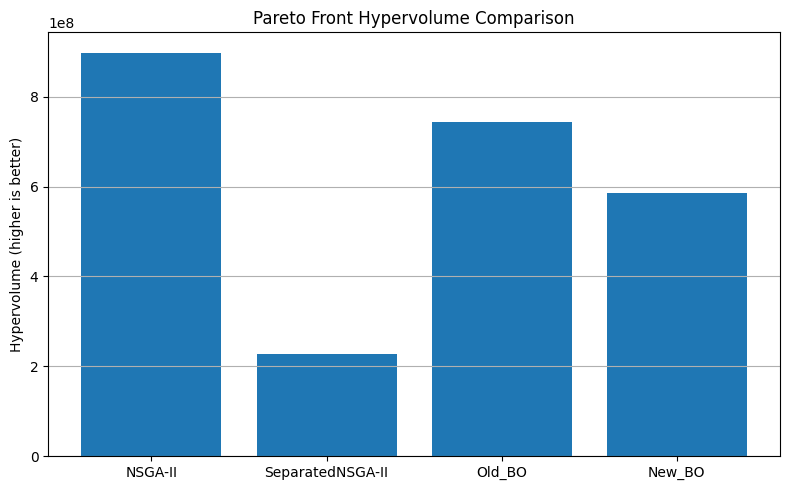

{'NSGA-II': 898651043.0308388,
 'SeparatedNSGA-II': 227544747.69152635,
 'Old_BO': 744558302.8700789,
 'New_BO': 585850489.8470347}

In [16]:
compare_pareto_hypervolumes(results_by_algorithm=results_by_algorithm, objectives=objectives)